# LangGraph Demo

This notebook demonstrates **LangGraph**, the most sophisticated framework for building stateful, multi-agent applications with complex workflows using graph-based architectures.

## Required Environment Variables

```
OPENAI_API_KEY    # Your OpenAI API key (required)
```

Please refer to the [README](README.md) for instructions on setting up environment variables.


In [ ]:
# If running standalone without the project setup:
# !pip install langgraph openai python-dotenv

  Using cached xxhash-3.5.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
  Using cached orjson-3.11.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (41 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 9.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.8 MB/s eta 0:00:00
Using cached xxhash-3.5.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
Using cached jsonpatch-1.33-py2.py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
from typing import Dict, List, Literal, TypedDict, Annotated
from dotenv import load_dotenv

# Load environment variables
load_dotenv(override=True)

# Import LangGraph components
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI

# For visualization
from IPython.display import Image, display

/mnt/sda/yifen/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LangGraph Core Components Loaded:
- **StateGraph:** Graph-based workflow orchestrator
- **State Management:** TypedDict-based state schemas
- **Conditional Logic:** Dynamic routing capabilities
- **LLM Integration:** ChatOpenAI for intelligent node processing

## 📊 State Management

In LangGraph, **State** is the cornerstone that makes complex workflows possible. Unlike other frameworks where data flows through function calls, LangGraph maintains a **persistent, shared state** that evolves through the workflow.


In [2]:
# Define our state schema using TypedDict
class TicketState(TypedDict):
    """State schema for our customer support ticket routing system"""
    # Ticket information
    ticket_id: str
    title: str
    description: str
    customer_tier: str

    # Processing state
    category: str
    priority: str
    assigned_agent: str

    # Workflow tracking
    processing_steps: Annotated[List[str], lambda x, y: x + y]  # List reducer
    status: str

    # Results
    resolution: str

# Example initial state
sample_state = TicketState(
    ticket_id="TKT-12345",
    title="Login Issues with Mobile App",
    description="Customer unable to log in using mobile app, web works fine",
    customer_tier="Premium",
    category="",
    priority="",
    assigned_agent="",
    processing_steps=[],
    status="New",
    resolution=""
)

print(sample_state)

{'ticket_id': 'TKT-12345', 'title': 'Login Issues with Mobile App', 'description': 'Customer unable to log in using mobile app, web works fine', 'customer_tier': 'Premium', 'category': '', 'priority': '', 'assigned_agent': '', 'processing_steps': [], 'status': 'New', 'resolution': ''}


### State Schema Defined: TicketState

**State Fields:**
- 📝 **Ticket Info:** ticket_id, title, description, customer_tier
- ⚙️ **Processing:** category, priority, assigned_agent
- 🔄 **Workflow:** processing_steps (with list reducer), status
- ✅ **Results:** resolution

## 📊 Visualizing the AI Workflow as a Graph

Before we demonstrate the workflow execution, let's visualize how LangGraph structures the workflow as a graph. This shows how the state will flow through each AI-powered decision node:

In [3]:
# Initialize LLM for AI-powered workflow
llm = ChatOpenAI(model="gpt-4o-mini")

# Node 1: Ticket Classifier with LLM
def classify_ticket(state: TicketState) -> dict:
    """Classify ticket into category using LLM analysis"""

    print(f"Classifying ticket: {state['ticket_id']}")

    # Use LLM to classify the ticket
    classification_prompt = f"""
    Analyze this support ticket and classify it into one of these categories:
    - Technical: Login issues, bugs, errors, system problems
    - Billing: Payment, subscription, pricing issues
    - General: All other inquiries

    Ticket Title: {state['title']}
    Ticket Description: {state['description']}

    Respond with ONLY the category name (Technical, Billing, or General).
    """

    response = llm.invoke([
        SystemMessage(content="You are a ticket classification expert."),
        HumanMessage(content=classification_prompt)
    ])

    category = response.content.strip()

    # Validate and default to General if unexpected response
    if category not in ["Technical", "Billing", "General"]:
        category = "General"

    # Return state update (partial update, not full state)
    return {
        "category": category,
        "processing_steps": [f"Classified as {category} by AI analysis"],
        "status": "Classified"
    }

# Node 2: Priority Router with LLM
def route_priority(state: TicketState) -> dict:
    """Determine ticket priority using LLM reasoning"""

    print(f"Routing priority for {state['category']} ticket from {state['customer_tier']} customer")

    # Use LLM to determine priority
    priority_prompt = f"""
    Determine the priority level for this support ticket based on:
    - Category: {state['category']}
    - Customer Tier: {state['customer_tier']}
    - Title: {state['title']}
    - Description: {state['description']}

    Priority Rules:
    - Premium customers with Technical issues should be High priority
    - Premium customers with other issues should be Medium priority
    - Standard customers with Technical issues should be Medium priority
    - Standard customers with other issues should be Low priority
    - Critical system outages should always be High priority

    Respond with ONLY the priority level (High, Medium, or Low).
    """

    response = llm.invoke([
        SystemMessage(content="You are a support ticket priority expert."),
        HumanMessage(content=priority_prompt)
    ])

    priority = response.content.strip()

    # Validate and set default
    if priority not in ["High", "Medium", "Low"]:
        priority = "Medium"

    step_msg = f"Priority set to {priority} by AI assessment ({state['customer_tier']} customer, {state['category']} issue)"

    return {
        "priority": priority,
        "processing_steps": [step_msg],
        "status": "Prioritized"
    }

# Node 3: Agent Matcher with LLM
def match_agent(state: TicketState) -> dict:
    """Assign appropriate agent using LLM matching"""

    print(f"Matching agent for {state['priority']} priority {state['category']} ticket")

    # Use LLM to match the best agent
    agent_prompt = f"""
    Match the best support agent for this ticket:
    - Category: {state['category']}
    - Priority: {state['priority']}
    - Customer Tier: {state['customer_tier']}
    - Issue: {state['title']}

    Available agents:
    - Senior Tech Support: For high-priority technical issues
    - Tech Support: For standard technical issues
    - Billing Specialist: For all billing-related issues
    - General Support: For general inquiries and low-priority issues

    Respond with ONLY the agent role name.
    """

    response = llm.invoke([
        SystemMessage(content="You are an expert at matching support tickets to the right agents."),
        HumanMessage(content=agent_prompt)
    ])

    agent = response.content.strip()

    # Validate agent assignment
    valid_agents = ["Senior Tech Support", "Tech Support", "Billing Specialist", "General Support"]
    if agent not in valid_agents:
        # Fallback logic based on category
        if state['category'] == "Technical":
            agent = "Tech Support"
        elif state['category'] == "Billing":
            agent = "Billing Specialist"
        else:
            agent = "General Support"

    step_msg = f"Assigned to {agent} by AI matching based on {state['category']}/{state['priority']}"

    return {
        "assigned_agent": agent,
        "processing_steps": [step_msg],
        "status": "Assigned"
    }

# Simple resolution generator for the demo
def generate_resolution(state: TicketState) -> dict:
    """Use LLM to generate a resolution for the ticket"""

    resolution_prompt = f"""
    Generate a brief, professional resolution message for this support ticket:

    Ticket: {state['title']}
    Category: {state['category']}
    Priority: {state['priority']}
    Assigned Agent: {state['assigned_agent']}
    Customer Tier: {state['customer_tier']}

    Create a resolution message (max 30 words) that confirms the issue was addressed.
    Be specific to the issue type and professional.
    """

    response = llm.invoke([
        SystemMessage(content="You are a support resolution specialist."),
        HumanMessage(content=resolution_prompt)
    ])

    return {
        "resolution": response.content.strip(),
        "processing_steps": state["processing_steps"] + ["Resolution generated by AI"],
        "status": "Resolved"
    }

# Demonstrate AI-powered state evolution
def demonstrate_ai_workflow():
    """Process a ticket through AI-powered workflow stages"""

    print("🤖 AI-Powered Ticket Processing Workflow")
    print("=" * 50)

    # Initial ticket state
    state = TicketState(
        ticket_id="TKT-12345",
        title="Cannot login to mobile app - urgent!",
        description="Login button not responding on iOS app, web version works fine. This is blocking my work.",
        customer_tier="Premium",
        category="",
        priority="",
        assigned_agent="",
        processing_steps=[],
        status="New",
        resolution=""
    )

    print("\n📥 Initial Ticket:")
    print(f"  ID: {state['ticket_id']}")
    print(f"  Title: {state['title']}")
    print(f"  Customer: {state['customer_tier']} tier")
    print(f"  Status: {state['status']}")

    print("\n" + "=" * 50)
    print("Starting AI Processing...")
    print("=" * 50)

    # Step 1: AI Classification
    print("\n🔍 Step 1: AI Classification")
    print("-" * 30)
    classification_result = classify_ticket(state)
    state.update(classification_result)
    print(f"  ✅ AI Decision: {state['category']}")
    print(f"  📝 Reasoning: {state['processing_steps'][-1]}")

    # Step 2: AI Priority Assignment
    print("\n⚡ Step 2: AI Priority Assignment")
    print("-" * 30)
    priority_result = route_priority(state)
    state["processing_steps"] = state["processing_steps"] + priority_result["processing_steps"]
    state["priority"] = priority_result["priority"]
    state["status"] = priority_result["status"]
    print(f"  ✅ AI Decision: {state['priority']} priority")
    print(f"  📝 Reasoning: {priority_result['processing_steps'][0]}")

    # Step 3: AI Agent Matching
    print("\n👤 Step 3: AI Agent Matching")
    print("-" * 30)
    agent_result = match_agent(state)
    state["processing_steps"] = state["processing_steps"] + agent_result["processing_steps"]
    state["assigned_agent"] = agent_result["assigned_agent"]
    state["status"] = agent_result["status"]
    print(f"  ✅ AI Decision: {state['assigned_agent']}")
    print(f"  📝 Reasoning: {agent_result['processing_steps'][0]}")

    # Step 4: AI Resolution Generation
    print("\n✅ Step 4: AI Resolution Generation")
    print("-" * 30)
    resolution_result = generate_resolution(state)
    state.update(resolution_result)
    print(f"  ✅ AI Resolution: {state['resolution']}")
    print(f"  📝 Status: {state['status']}")

    # Final Summary
    print("\n" + "=" * 50)
    print("📊 Final State Summary")
    print("=" * 50)
    print(f"  Ticket ID: {state['ticket_id']}")
    print(f"  Category: {state['category']}")
    print(f"  Priority: {state['priority']}")
    print(f"  Assigned To: {state['assigned_agent']}")
    print(f"  Status: {state['status']}")
    print(f"  Resolution: {state['resolution']}")

    print("\n🔄 Complete Processing Trail:")
    for i, step in enumerate(state['processing_steps'], 1):
        print(f"  {i}. {step}")

    return state

# Run the AI-powered demonstration
try:
    final_state = demonstrate_ai_workflow()

    print("\n✨ Key Observations:")
    print("  • Each decision was made by AI analyzing the context")
    print("  • State evolved through the workflow with full history")
    print("  • Business logic was applied intelligently, not hard-coded")
    print("  • Complete audit trail maintained for compliance")

except Exception as e:
    print(f"\n⚠️ Demo Error: {str(e)}")
    print("\nThis might be due to:")
    print("  • Missing OpenAI API key in environment variables")
    print("  • API rate limits or network issues")
    print("  • Please ensure OPENAI_API_KEY is set in your .env file")

🤖 AI-Powered Ticket Processing Workflow

📥 Initial Ticket:
  ID: TKT-12345
  Title: Cannot login to mobile app - urgent!
  Customer: Premium tier
  Status: New

Starting AI Processing...

🔍 Step 1: AI Classification
------------------------------
Classifying ticket: TKT-12345
  ✅ AI Decision: Technical
  📝 Reasoning: Classified as Technical by AI analysis

⚡ Step 2: AI Priority Assignment
------------------------------
Routing priority for Technical ticket from Premium customer
  ✅ AI Decision: High priority
  📝 Reasoning: Priority set to High by AI assessment (Premium customer, Technical issue)

👤 Step 3: AI Agent Matching
------------------------------
Matching agent for High priority Technical ticket
  ✅ AI Decision: Senior Tech Support
  📝 Reasoning: Assigned to Senior Tech Support by AI matching based on Technical/High

✅ Step 4: AI Resolution Generation
------------------------------
  ✅ AI Resolution: Dear [Customer's Name], 

We have successfully resolved your login issue with 

🔍 AI Workflow Graph - The Path We're About to Execute:


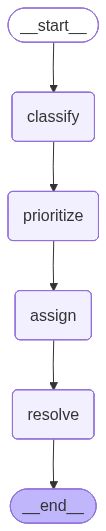


📝 Graph Explanation:
  • Each box represents an AI-powered decision node
  • Arrows show the flow of state through the workflow
  • The state accumulates information at each step
  • Every node uses LLM intelligence for decisions


In [4]:
# Create the demonstration workflow as a LangGraph
def create_demo_workflow():
    """Build the AI demonstration workflow as a graph"""

    # Initialize the StateGraph
    workflow = StateGraph(TicketState)

    # Add the 4 nodes from our demonstration
    workflow.add_node("classify", classify_ticket)
    workflow.add_node("prioritize", route_priority)
    workflow.add_node("assign", match_agent)
    workflow.add_node("resolve", generate_resolution)

    # Add sequential edges connecting all nodes
    workflow.add_edge("classify", "prioritize")
    workflow.add_edge("prioritize", "assign")
    workflow.add_edge("assign", "resolve")
    workflow.add_edge("resolve", END)

    # Set the entry point
    workflow.set_entry_point("classify")

    # Compile the graph
    app = workflow.compile()

    return app

# Create and visualize the demo workflow
demo_app = create_demo_workflow()

print("🔍 AI Workflow Graph - The Path We're About to Execute:")
print("=" * 55)
display(Image(demo_app.get_graph().draw_mermaid_png()))

print("\n📝 Graph Explanation:")
print("  • Each box represents an AI-powered decision node")
print("  • Arrows show the flow of state through the workflow")
print("  • The state accumulates information at each step")
print("  • Every node uses LLM intelligence for decisions")

In [5]:
# Now let's execute the workflow using the graph we just visualized
def execute_graph_workflow():
    """Execute the workflow through the LangGraph we created"""

    print("🚀 Executing the Workflow Through LangGraph")
    print("=" * 50)

    # Prepare a test ticket
    test_ticket = {
        "ticket_id": "TKT-GRAPH-001",
        "title": "Mobile app crashes on startup",
        "description": "The iOS app crashes immediately after opening. This is affecting my productivity.",
        "customer_tier": "Premium",
        "category": "",
        "priority": "",
        "assigned_agent": "",
        "processing_steps": [],
        "status": "New",
        "resolution": ""
    }

    print("\n📥 Input Ticket:")
    print(f"  ID: {test_ticket['ticket_id']}")
    print(f"  Title: {test_ticket['title']}")
    print(f"  Customer: {test_ticket['customer_tier']} tier")
    print(f"  Status: {test_ticket['status']}")

    print("\n🔄 Processing through LangGraph...")
    print("-" * 40)

    try:
        # Execute the workflow using the graph
        result = demo_app.invoke(test_ticket)

        print("\n✅ Graph Execution Complete!")
        print("=" * 50)

        print("\n📊 Final State After Graph Processing:")
        print(f"  Ticket ID: {result['ticket_id']}")
        print(f"  Category: {result['category']}")
        print(f"  Priority: {result['priority']}")
        print(f"  Assigned Agent: {result['assigned_agent']}")
        print(f"  Status: {result['status']}")
        print(f"  Resolution: {result['resolution']}")

        print("\n🔄 Execution Path Through Graph:")
        for i, step in enumerate(result['processing_steps'], 1):
            print(f"  {i}. {step}")

        print("\n💡 Key Insights:")
        print("  • The graph orchestrated the entire workflow")
        print("  • Each node processed the state sequentially")
        print("  • State accumulated through the execution path")
        print("  • LLM decisions were made at each node")

        return result

    except Exception as e:
        print(f"\n⚠️ Execution Error: {str(e)}")
        print("\nThis might be due to:")
        print("  • Missing OpenAI API key")
        print("  • API rate limits")
        print("  • Network issues")
        return None

# Execute the workflow through the graph
print("Now let's run a ticket through the graph we just visualized:\n")
graph_result = execute_graph_workflow()

if graph_result:
    print("\n🎯 Graph-Based Workflow Success!")
    print("The LangGraph successfully processed the ticket through all nodes.")

Now let's run a ticket through the graph we just visualized:

🚀 Executing the Workflow Through LangGraph

📥 Input Ticket:
  ID: TKT-GRAPH-001
  Title: Mobile app crashes on startup
  Customer: Premium tier
  Status: New

🔄 Processing through LangGraph...
----------------------------------------
Classifying ticket: TKT-GRAPH-001
Routing priority for Technical ticket from Premium customer
Matching agent for High priority Technical ticket

✅ Graph Execution Complete!

📊 Final State After Graph Processing:
  Ticket ID: TKT-GRAPH-001
  Category: Technical
  Priority: High
  Assigned Agent: Senior Tech Support
  Status: Resolved
  Resolution: Dear Customer, we have resolved the crashing issue upon startup for the mobile app. Please update to the latest version and let us know if you experience any further problems.

🔄 Execution Path Through Graph:
  1. Classified as Technical by AI analysis
  2. Priority set to High by AI assessment (Premium customer, Technical issue)
  3. Assigned to Senior

## 🎯 AI-Powered Workflow Demonstration

Now let's see how LangGraph manages state evolution through the **actual AI-powered workflow** we just visualized. We'll process a support ticket through four key stages, with real LLM decision-making at each step.

### What We're Building:
A **Customer Support Ticket Routing System** that uses AI to:

1. **📂 Classification**: AI analyzes the ticket content and categorizes it (Technical/Billing/General)
2. **⚡ Priority Assignment**: AI determines urgency based on category, customer tier, and issue severity
3. **👤 Agent Matching**: AI matches the ticket to the best available support agent based on skills
4. **✅ Resolution**: AI generates a professional resolution summary

### Key Insight:
Unlike traditional workflows with hard-coded rules, each decision is made by an LLM that considers context, applies business logic, and makes intelligent routing decisions. The state evolves as it flows through the workflow, building a complete audit trail.

### 🎉 State Evolution with AI Complete!

We've just demonstrated how **state flows through an AI-powered workflow** with real LLM decision-making at each step. The state evolved from an empty ticket to a fully processed and resolved case, with complete tracking of every AI decision.

**Next**: Let's dive deeper into how LangGraph's **Nodes and Edges** architecture makes these complex workflows possible.

## 🔘 Nodes & Edges

**Nodes** and **Edges** are the building blocks of LangGraph workflows. Together, they create sophisticated processing pipelines.

### Nodes: State Processing Functions
- **Input**: Current state
- **Processing**: Business logic, LLM calls, API requests
- **Output**: Updated state (partial or complete)
- **Features**: Error handling, logging, side effects

### Edges: Flow Control Mechanisms
- **Fixed Edges**: Always go to the same next node
- **Conditional Edges**: Dynamic routing based on state
- **END Edge**: Terminate workflow

### Node-to-Node Communication:
Unlike function chaining, nodes communicate through **shared state**. Each node sees the complete workflow history and can make informed decisions.

## 🔀 Conditional Edges & Dynamic Workflows

**Conditional Edges** are where LangGraph truly shines. Unlike fixed linear flows, conditional edges enable **dynamic routing** based on state values, creating sophisticated branching workflows.

### Conditional Edge Capabilities:
- **Dynamic Routing**: Different paths based on state conditions
- **Multi-Path Logic**: Handle success/error/retry scenarios
- **State-Based Decisions**: Route based on any state field
- **Complex Conditions**: Multiple criteria and nested logic
- **Cycles & Loops**: Retry mechanisms and iterative processing

In [6]:
# Enhanced state for conditional workflows
class EnhancedTicketState(TypedDict):
    """Enhanced state with conditional routing fields"""
    # Basic ticket info
    ticket_id: str
    title: str
    description: str
    customer_tier: str

    # Processing state
    category: str
    priority: str
    assigned_agent: str

    # Conditional routing fields
    needs_escalation: bool

    # Workflow tracking
    processing_steps: Annotated[List[str], lambda x, y: x + y]
    status: str
    resolution: str

# Initialize LLMs for different agent levels
llm_junior = ChatOpenAI(model="gpt-4o-mini")  # Normal agent
llm_senior = ChatOpenAI(model="gpt-4")  # Senior agent (more capable)

print("🤖 LLM Agents Initialized:")
print("  • Junior Agent: GPT-4o-mini (efficient for standard issues)")
print("  • Senior Agent: GPT-4 (advanced reasoning for complex issues)")

# Node for escalation check
def escalation_check(state: EnhancedTicketState) -> dict:
    """Use LLM to determine if ticket needs escalation to senior agent"""

    print(f"Checking if ticket needs escalation...")

    # Use LLM for intelligent escalation decision
    escalation_prompt = f"""
    Analyze if this ticket needs escalation to a senior agent:

    Ticket Details:
    - Priority: {state['priority']}
    - Customer Tier: {state['customer_tier']}
    - Category: {state['category']}
    - Title: {state['title']}
    - Description: {state['description']}

    Escalation Criteria:
    - High priority tickets should be escalated
    - Premium customers with technical issues should be escalated
    - Any mention of "critical", "urgent", "outage", "production", or "down" should be escalated
    - Complex technical problems requiring deep expertise should be escalated

    Respond with ONLY "YES" or "NO" for escalation.
    """

    response = llm.invoke([
        SystemMessage(content="You are an escalation specialist who determines if tickets need senior attention."),
        HumanMessage(content=escalation_prompt)
    ])

    needs_escalation = response.content.strip().upper() == "YES" # needs_escalation = True if response.content.strip().upper() == "YES" else needs_escalation = False      

    step_msg = f"Escalation decision: {'Route to Senior Agent (GPT-4)' if needs_escalation else 'Route to Normal Agent (GPT-4o-mini)'}"

    return {
        "needs_escalation": needs_escalation,
        "processing_steps": [step_msg],
        "status": "Escalation Checked"
    }

# Senior Agent resolution (using GPT-4)
def senior_agent_resolution(state: EnhancedTicketState) -> dict:
    """Senior agent with GPT-4 handles complex escalated tickets"""

    print(f"🔴 SENIOR AGENT (GPT-4) handling escalated ticket")

    # Use more capable GPT-4 for complex problem solving
    resolution_prompt = f"""
    You are a SENIOR support agent with advanced expertise. This ticket has been escalated to you.

    Ticket Details:
    - Title: {state['title']}
    - Description: {state['description']}
    - Category: {state['category']}
    - Priority: {state['priority']}
    - Customer Tier: {state['customer_tier']}

    As a senior agent with GPT-4 capabilities, provide:
    1. Deep technical analysis of the issue
    2. Comprehensive solution with detailed steps
    3. Preventive measures to avoid future occurrences

    Create a detailed resolution (50-75 words) that demonstrates senior-level expertise.
    """

    response = llm_senior.invoke([
        SystemMessage(content="You are a senior technical expert with deep knowledge and problem-solving capabilities."),
        HumanMessage(content=resolution_prompt)
    ])

    resolution_msg = f"[SENIOR AGENT - GPT-4] {response.content.strip()}"

    return {
        "assigned_agent": "Senior Agent (GPT-4)",
        "resolution": resolution_msg,
        "processing_steps": ["Escalated ticket resolved by Senior Agent using GPT-4's advanced capabilities"],
        "status": "Resolved by Senior Agent"
    }

# Normal Agent resolution (using GPT-4o-mini)
def normal_agent_resolution(state: EnhancedTicketState) -> dict:
    """Normal agent with GPT-4o-mini handles standard tickets"""

    print(f"🟢 NORMAL AGENT (GPT-4o-mini) handling standard ticket")

    # Use efficient GPT-4o-mini for standard issues
    resolution_prompt = f"""
    You are a standard support agent handling routine tickets.

    Ticket Details:
    - Title: {state['title']}
    - Description: {state['description']}
    - Category: {state['category']}
    - Priority: {state['priority']}

    Provide a helpful resolution (25-30 words) for this standard issue.
    Be concise and practical.
    """

    response = llm_junior.invoke([
        SystemMessage(content="You are a helpful support agent handling routine customer issues."),
        HumanMessage(content=resolution_prompt)
    ])

    resolution_msg = f"[NORMAL AGENT - GPT-4o-mini] {response.content.strip()}"

    return {
        "assigned_agent": "Normal Agent (GPT-4o-mini)",
        "resolution": resolution_msg,
        "processing_steps": ["Standard ticket resolved by Normal Agent using GPT-4o-mini"],
        "status": "Resolved by Normal Agent"
    }

print("\n📊 Conditional Workflow Architecture:")
print("  🔀 Escalation Check: AI determines ticket complexity")
print("  🔴 Escalated Path → Senior Agent (GPT-4)")
print("     • Handles complex technical issues")
print("     • Provides deep analysis and comprehensive solutions")
print("     • No approval needed - senior agents have authority")
print("  🟢 Normal Path → Normal Agent (GPT-4o-mini)")
print("     • Handles routine customer issues")
print("     • Provides quick, practical solutions")
print("     • Efficient processing for standard tickets")

print("\n💡 Key Difference:")
print("  • Escalated tickets get MORE CAPABLE AI (GPT-4)")
print("  • Normal tickets get EFFICIENT AI (GPT-4o-mini)")
print("  • Different paths lead to DIFFERENT OUTCOMES")

🤖 LLM Agents Initialized:
  • Junior Agent: GPT-4o-mini (efficient for standard issues)
  • Senior Agent: GPT-4 (advanced reasoning for complex issues)

📊 Conditional Workflow Architecture:
  🔀 Escalation Check: AI determines ticket complexity
  🔴 Escalated Path → Senior Agent (GPT-4)
     • Handles complex technical issues
     • Provides deep analysis and comprehensive solutions
     • No approval needed - senior agents have authority
  🟢 Normal Path → Normal Agent (GPT-4o-mini)
     • Handles routine customer issues
     • Provides quick, practical solutions
     • Efficient processing for standard tickets

💡 Key Difference:
  • Escalated tickets get MORE CAPABLE AI (GPT-4)
  • Normal tickets get EFFICIENT AI (GPT-4o-mini)
  • Different paths lead to DIFFERENT OUTCOMES


In [7]:
# Define conditional routing functions
def route_after_escalation_check(state: EnhancedTicketState) -> Literal["senior_agent", "normal_agent"]:
    """Route based on escalation needs"""
    if state['needs_escalation']:
        return "senior_agent"  # Goes to GPT-4 powered senior agent
    else:
        return "normal_agent"  # Goes to GPT-4o-mini powered normal agent

print("🔀 Routing Logic Defined:")
print("  • needs_escalation = True → 'senior_agent' (GPT-4)")
print("  • needs_escalation = False → 'normal_agent' (GPT-4o-mini)")
print("\n✨ This creates truly different paths with different AI capabilities!")

🔀 Routing Logic Defined:
  • needs_escalation = True → 'senior_agent' (GPT-4)
  • needs_escalation = False → 'normal_agent' (GPT-4o-mini)

✨ This creates truly different paths with different AI capabilities!


In [8]:
# Build the conditional workflow graph with different agent paths
def create_conditional_workflow():
    """Create a workflow with truly different conditional paths"""

    # Initialize the StateGraph with enhanced state
    workflow = StateGraph(EnhancedTicketState)

    # Add all nodes
    workflow.add_node("classifier", classify_ticket)
    workflow.add_node("priority_router", route_priority)
    workflow.add_node("escalation_check", escalation_check)
    workflow.add_node("senior_agent", senior_agent_resolution)  # GPT-4 powered
    workflow.add_node("normal_agent", normal_agent_resolution)  # GPT-4o-mini powered

    # Add fixed edges for initial processing
    workflow.add_edge("classifier", "priority_router")
    workflow.add_edge("priority_router", "escalation_check")

    # Add conditional edge after escalation check - KEY DIFFERENCE!
    workflow.add_conditional_edges(
        "escalation_check",
        route_after_escalation_check,
        {
            "senior_agent": "senior_agent",  # Escalated → GPT-4
            "normal_agent": "normal_agent"   # Normal → GPT-4o-mini
        }
    )

    # Both agents complete the resolution - no more approval gates
    workflow.add_edge("senior_agent", END)
    workflow.add_edge("normal_agent", END)

    # Set entry point
    workflow.set_entry_point("classifier")

    # Compile the graph
    app = workflow.compile()

    return app

# Create the conditional workflow
conditional_app = create_conditional_workflow()

print("🎯 Conditional Workflow Created!")
print("\n📊 Workflow Paths:")
print("  Path 1 (Escalated): classify → prioritize → escalation_check → senior_agent (GPT-4) → END")
print("  Path 2 (Normal): classify → prioritize → escalation_check → normal_agent (GPT-4o-mini) → END")
print("\n💡 Key Innovation:")
print("  • Different paths use DIFFERENT AI MODELS")
print("  • Senior path gets more capable but expensive GPT-4")
print("  • Normal path gets efficient GPT-4o-mini")
print("  • No redundant approval gates - agents resolve directly")

🎯 Conditional Workflow Created!

📊 Workflow Paths:
  Path 1 (Escalated): classify → prioritize → escalation_check → senior_agent (GPT-4) → END
  Path 2 (Normal): classify → prioritize → escalation_check → normal_agent (GPT-4o-mini) → END

💡 Key Innovation:
  • Different paths use DIFFERENT AI MODELS
  • Senior path gets more capable but expensive GPT-4
  • Normal path gets efficient GPT-4o-mini
  • No redundant approval gates - agents resolve directly


### Workflow Architecture:
📥 **Entry:** classifier  
🔍 **Initial Processing:** classifier → priority_router → escalation_check  
🔀 **Conditional Branch:** escalation_check → [senior_agent | normal_agent]  
🏁 **Exit:** [senior_agent | normal_agent] → END  

### Two Distinct Paths:
🔴 **Senior Path (Escalated):**
- Uses GPT-4 (more capable, expensive)
- Handles complex technical issues
- Provides comprehensive solutions
- Direct resolution without approval

🟢 **Normal Path (Standard):**
- Uses GPT-4o-mini (efficient, cost-effective)
- Handles routine inquiries
- Provides quick solutions
- Direct resolution without bureaucracy

### Key Innovation:
✅ **Different AI Models for Different Needs**
✅ **Cost Optimization Through Intelligent Routing**
✅ **No Redundant Approval Gates**
✅ **Clear Path Differentiation**

📊 Conditional Workflow Graph Visualization:
Notice the branching paths showing conditional routing!



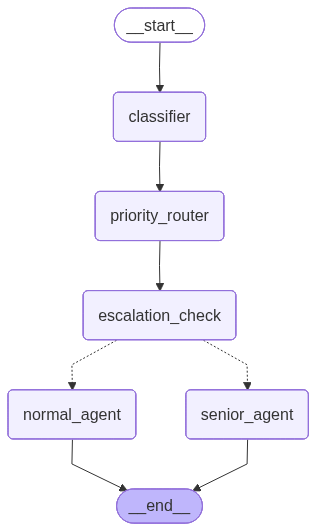

In [9]:
# Visualize the conditional workflow graph with all edges
print("📊 Conditional Workflow Graph Visualization:")
print("Notice the branching paths showing conditional routing!\n")
display(Image(conditional_app.get_graph().draw_mermaid_png()))

In [10]:
# Test different conditional scenarios showing different AI agents
def test_conditional_scenarios():
    """Test scenarios to show GPT-4 vs GPT-4o-mini routing"""

    print("🧪 Testing Conditional Workflow - Different AI Agents")
    print("=" * 60)

    # Scenario 1: Critical issue - should go to Senior Agent (GPT-4)
    print("\n📛 Scenario 1: Critical Production Outage")
    print("-" * 50)
    scenario1 = {
        "ticket_id": "TKT-CRITICAL",
        "title": "URGENT: Production database down - all users affected",
        "description": "Critical system failure, complete outage, revenue impact",
        "customer_tier": "Premium",
        "category": "",
        "priority": "",
        "assigned_agent": "",
        "needs_escalation": False,
        "processing_steps": [],
        "status": "New",
        "resolution": ""
    }

    print("Expected: → Senior Agent (GPT-4) for complex resolution")

    # Scenario 2: Simple question - should go to Normal Agent (GPT-4o-mini)
    print("\n💬 Scenario 2: Basic Account Question")
    print("-" * 50)
    scenario2 = {
        "ticket_id": "TKT-SIMPLE",
        "title": "How do I change my email address?",
        "description": "I want to update my account email",
        "customer_tier": "Standard",
        "category": "",
        "priority": "",
        "assigned_agent": "",
        "needs_escalation": False,
        "processing_steps": [],
        "status": "New",
        "resolution": ""
    }

    print("Expected: → Normal Agent (GPT-4o-mini) for quick resolution")

    # Test both scenarios
    scenarios = [("Critical", scenario1), ("Simple", scenario2)]

    for scenario_name, initial_state in scenarios:
        print(f"\n🔄 Executing {scenario_name} Scenario...")
        print("-" * 30)

        try:
            result = conditional_app.invoke(initial_state)

            print(f"\n✅ {scenario_name} Scenario Completed!")
            print(f"  📊 Results:")
            print(f"  • Category: {result['category']}")
            print(f"  • Priority: {result['priority']}")
            print(f"  • Escalated: {result['needs_escalation']}")
            print(f"  • Assigned to: {result['assigned_agent']}")

            print(f"\n  📝 Resolution:")
            print(f"  {result['resolution'][:200]}...")

            print(f"\n  🔄 Execution Path:")
            for i, step in enumerate(result['processing_steps'], 1):
                print(f"    {i}. {step}")

            # Highlight the key difference
            if "GPT-4)" in result['assigned_agent']:
                print("\n  🔴 Used SENIOR AGENT with GPT-4 (more capable)")
            else:
                print("\n  🟢 Used NORMAL AGENT with GPT-4o-mini (efficient)")

        except Exception as e:
            print(f"  ⚠️ Error: {str(e)}")

# Run the scenario tests
test_conditional_scenarios()

print("\n" + "=" * 60)
print("🎯 Conditional Workflow Demonstration Complete!")
print("\n✨ Key Achievements:")
print("  • Critical issues → Senior Agent (GPT-4)")
print("  • Simple issues → Normal Agent (GPT-4o-mini)")
print("  • Different paths = Different AI capabilities")
print("  • Cost optimization through intelligent routing")
print("  • No redundant approval gates")

🧪 Testing Conditional Workflow - Different AI Agents

📛 Scenario 1: Critical Production Outage
--------------------------------------------------
Expected: → Senior Agent (GPT-4) for complex resolution

💬 Scenario 2: Basic Account Question
--------------------------------------------------
Expected: → Normal Agent (GPT-4o-mini) for quick resolution

🔄 Executing Critical Scenario...
------------------------------
Classifying ticket: TKT-CRITICAL
Routing priority for Technical ticket from Premium customer
Checking if ticket needs escalation...
🔴 SENIOR AGENT (GPT-4) handling escalated ticket

✅ Critical Scenario Completed!
  📊 Results:
  • Category: Technical
  • Priority: High
  • Escalated: True
  • Assigned to: Senior Agent (GPT-4)

  📝 Resolution:
  [SENIOR AGENT - GPT-4] 1. Technical Analysis: The outage indicates a database crash which could be due to issues such as corrupted data, server failure, hardware faults, or network issues. Thorough lo...

  🔄 Execution Path:
    1. Classi

## 📋 Summary

This notebook demonstrated **LangGraph's sophisticated approach** to building stateful, graph-based AI workflows with LLM intelligence at every decision point.

### 📊 **State Management**
✅ **TypedDict schemas** - Type-safe, structured state definitions  
✅ **State evolution** - Data that flows and grows through workflow  
✅ **State reducers** - Intelligent handling of concurrent updates  
✅ **State inspection** - Debug and monitor workflow progress  

### 🔘 **Nodes & Edges**
✅ **AI-powered nodes** - LLM intelligence in every processing function  
✅ **Fixed edges** - Deterministic workflow transitions  
✅ **Node communication** - Shared state instead of function chaining  
✅ **Error handling** - Graceful failure management with validation  

### 🔀 **Conditional Logic**
✅ **Dynamic routing** - State-based decision making  
✅ **Multi-path workflows** - Handle complex scenarios with AI  
✅ **Business rules** - LLM-enforced conditional logic  
✅ **Intelligent decisions** - AI-driven path selection  

## 📚 **Resources**

- **Documentation**: [LangGraph Docs](https://langgraph.readthedocs.io/)
- **GitHub**: [langchain-ai/langgraph](https://github.com/langchain-ai/langgraph)
- **Tutorials**: LangChain Academy LangGraph course
- **Community**: LangChain Discord #langgraph channel

